## The Freeman Model

The Freeman model classifies gentrification as occurring in an area where the median household income and share of housing built in the prior 20 years are both less than the metro-area values. For an area to be gentrified, the share of residents with degree equivalent qualifications also has to be greater than the metro value, and there needs to be an increase in house prices.

We will adapt the model by checking the following (where weight = w):
* Is median household income less than the city average, for that year? Yes: w = 0.25 and No: w = 0
* Is the proportion of housing built less than the average borough, for that year? Yes: w = 0.25 and No: w = 0
* Is the proportion of residents with degree equivalent qualifications more than the average borough, for that year? Yes: w = 0.25 and No: w = 0
* Have house prices increased? Yes: w = 0.25 and No: w = 0
<br><br> An area which hasn't been gentrified/is in the early stages of gentrification will have a low/medium score. An area with a high score has either already been gentrified or isn't an area where gentrification would occur.


Datasets required:
* Median household income (approximate using yearly median earnings - assume proportionality)
* Net additional dwellings
* Degree equivalent qualifications
* Average house price

In [25]:
# Install dependencies
## Libraries for data manipulation
import numpy as np
import pandas as pd
import einops
from matplotlib import pyplot as plt

## Libraries for model training
from xgboost import XGBRegressor
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("success!")

success!


In [3]:
# Read in the datasets
income_df = pd.read_excel("datasets/cleaned/yearly_median_earnings.xlsx", index_col='Area')
new_homes_df = pd.read_excel("datasets/cleaned/net_additional_dwellings.xlsx", index_col='Area')
degrees_df = pd.read_excel("datasets/cleaned/degree_equivalent_qualifs.xlsx", index_col='Area')
house_price_df = pd.read_excel("datasets/cleaned/average_house_price.xlsx", index_col='Area')
house_price_2003 = pd.read_excel("datasets/cleaned/house_price_2003.xlsx", index_col='Area')

# Create a dictionary to store all data for 'London'
london_dict = {"income": income_df.loc['London'],
               "new_homes": new_homes_df.loc['London'],
               "degrees": degrees_df.loc['London'],
               "house_price": house_price_df.loc['London']}

# Drop the 'London' row from the dataset, so that only the boroughs remain
income_df = income_df.drop('London')
new_homes_df = new_homes_df.drop('London')
degrees_df = degrees_df.drop('London')
house_price_df = house_price_df.drop('London')
house_price_2003 = house_price_2003.drop('London')

# Remove 'City of London' row as data is incomplete and also isn't recommended for investment
new_homes_df = new_homes_df.drop('City of London')
house_price_df = house_price_df.drop('City of London')
house_price_2003 = house_price_2003.drop('City of London')


In [4]:
# Create NumPy arrays and flatten into 1d vector
income_np = einops.rearrange(income_df.to_numpy(), 'borough year -> (borough year)', borough=32)
new_homes_np = einops.rearrange(new_homes_df.to_numpy(), 'borough year -> (borough year)', borough=32)
degrees_np = einops.rearrange(degrees_df.to_numpy(), 'borough year -> (borough year)', borough=32)
house_price_np = einops.rearrange(house_price_df.to_numpy(), 'borough year -> (borough year)', borough=32)

# Create DataFrame to store variables and Freeman Model values
index_lst = [str(x) + ' ' + str(y) for x in list(income_df.index) for y in range(2004,2020)]
freeman_df = pd.DataFrame(np.column_stack((income_np, new_homes_np, degrees_np, house_price_np)), columns = ['income', 'new_homes', 'degrees', 'house_price'], index=index_lst)
freeman_df['freeman_score'] = 0
freeman_df

# Calculate scores based on the Freeman Model for each row
for i in range(512):
    index = freeman_df.iloc[i].name
    year = int(freeman_df.iloc[i].name[-4:])

    # Check income condition
    avg_income = london_dict["income"].loc[year]
    if freeman_df.loc[index].income < avg_income:
        freeman_df.loc[index, 'freeman_score'] += 0.25
    
    # Check housing condition
    avg_new_homes = london_dict["new_homes"].loc[year] / 33     # total new homes in London divided by no. of boroughs gives average new homes per borough
    if freeman_df.loc[index].new_homes < avg_new_homes:
        freeman_df.loc[index, 'freeman_score'] += 0.25
    
    # Check degree qualification condition
    avg_degrees = london_dict["degrees"].loc[year]
    if freeman_df.loc[index].degrees > avg_degrees:
        freeman_df.loc[index, 'freeman_score'] += 0.25

    # Check house prices condition
    if year == 2004:
        borough = freeman_df.loc[index].name[:-5]
        if house_price_2003.loc[borough].loc[2003] < freeman_df.loc[index].house_price:
            freeman_df.loc[index, 'freeman_score'] += 0.25
    else:
        if freeman_df.iloc[i-1].house_price < freeman_df.loc[index].house_price:
            freeman_df.loc[index, 'freeman_score'] += 0.25
        
freeman_df

,income,new_homes,degrees,house_price,freeman_score
Barking and Dagenham 2004,18725.2,62.0,15.980630,158176.0,0.75
Barking and Dagenham 2005,19505.2,362.0,16.726835,163361.0,0.75
Barking and Dagenham 2006,21715.2,268.0,16.752577,167853.0,0.75
Barking and Dagenham 2007,23228.4,307.0,19.660194,184910.0,0.75
Barking and Dagenham 2008,23394.8,716.0,23.488372,187357.0,0.75
...,...,...,...,...,...
Westminster 2015,34112.0,749.0,66.700000,964643.0,0.75
Westminster 2016,34710.0,908.0,66.100000,995543.0,0.75
Westminster 2017,38001.6,1342.0,67.300000,1064772.0,0.50
Westminster 2018,39369.2,1143.0,72.600000,1020026.0,0.25


In [22]:
# Shuffle data for training and testing
freeman_shuffled = shuffle(freeman_df.copy())

# Split shuffled data into X and y
X = freeman_shuffled.iloc[:,:4]
Y = freeman_shuffled.iloc[:,4]

# Split data into train and test sets
seed = 7
test_size = 0.9
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Fit model to training data
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [23]:
# Make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
ms_error = mean_squared_error(y_test, predictions)
print("Mean Squared Error: %.2f%%" % (ms_error * 100.0))

Mean Squared Error: 18.70%


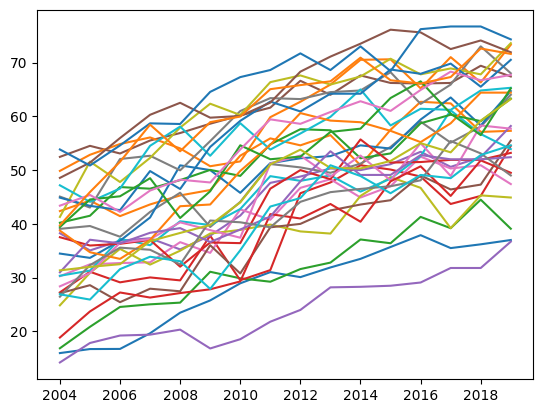

In [27]:
plt.plot(degrees_df.transpose())

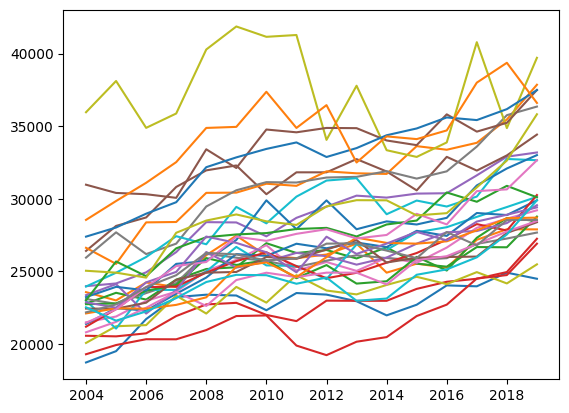

In [29]:
plt.plot(income_df.transpose())

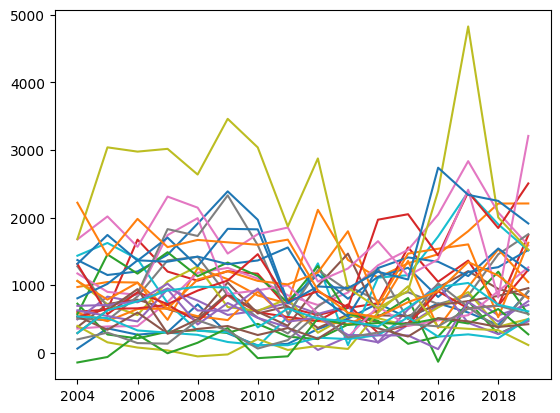

In [35]:
# new_homes_df.transpose().plot()
plt.plot(new_homes_df.transpose())


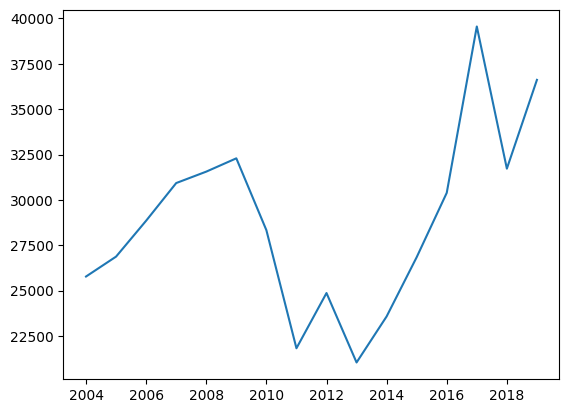

In [31]:
ldn_homes = london_dict["new_homes"]
plt.plot(ldn_homes)

**For Net New Builds** 
These fluctutaions have a very large variance in some cases, and a more complex model may account for this. For our purposes, this acts as a reasonable modelling assumption. 